**Load all the features saved as numpy array**

In [ ]:
# Load the pre-extracted image features and question embeddings.
# This retrieves the saved feature arrays from the previous steps.
# Loading these features allows us to proceed with model training without re-extracting them.

train_features = np.load("train_features.npy")  # (num_train_samples, 2048)
val_features = np.load("val_features.npy")  # (num_val_samples, 2048)

map image feature for each question row to get the same sampled dataset

In [ ]:
# Map image features to each question row based on image ID.
# This ensures that each question in the filtered DataFrames is associated with its corresponding image features.
# It handles cases where the order of questions might not match the order of extracted image features.

#Load features from filtered image IDs
train_image_features = dict(zip(df_train_filtered['image_id'], train_features)) # Create a dictionary for train features
val_image_features = dict(zip(df_val_filtered['image_id'], val_features)) # Create a dictionary for val features

# Function to get the image feature for each question row
def get_image_features_for_questions(df, image_features_dict):
    image_features = []
    for img_id in df['image_id']:
        image_features.append(image_features_dict.get(img_id, np.zeros(2048)))  # Default to zero if missing
    return np.array(image_features)

# Get the image features for the filtered train and val question rows
train_image_features_for_questions = get_image_features_for_questions(df_train_filtered, train_image_features)
val_image_features_for_questions = get_image_features_for_questions(df_val_filtered, val_image_features)

# Print out the shapes to confirm they match the number of rows
print(f"Train Image Features Shape: {train_image_features_for_questions.shape}")
print(f"Val Image Features Shape: {val_image_features_for_questions.shape}")

Train Image Features Shape: (53389, 2048)
Val Image Features Shape: (26769, 2048)


In [ ]:
train_question_embeddings = np.load("bert_embeddings_train.npy")  # (num_train_samples, 768)
train_answers = np.load("train_answers.npy")

In [ ]:
val_question_embeddings = np.load("bert_embeddings_val.npy")  # (num_val_samples, 768)
val_answers = np.load("val_answers.npy")  # (num_val_samples, 181)

# Model


**Using Tuned Approach 2: Gated Fusion network as the best model**


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Multiply, Add, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import TopKCategoricalAccuracy

# Set hyperparameters
dropout_rate = 0.3
hidden_dim = 1024
num_classes = 181

# Inputs
image_input = Input(shape=(2048,), name="image_input")
text_input = Input(shape=(768,), name="text_input")

# Projections
img_proj = Dense(hidden_dim, activation='relu', name="img_projection")(image_input)
text_proj = Dense(hidden_dim, activation='relu', name="text_projection")(text_input)

# Gating
gate_img = Dense(hidden_dim, activation='sigmoid', name="gate_img")(img_proj)
gate_text = Dense(hidden_dim, activation='sigmoid', name="gate_text")(text_proj)

gated_img = Multiply(name="gated_img")([img_proj, gate_img])
gated_text = Multiply(name="gated_text")([text_proj, gate_text])

# Fuse (concatenation instead of Add)
fused = Add(name="fused_features")([gated_img, gated_text])  # Shape: (batch, 512)

# FC block 1
fc1 = Dense(512, activation='relu')(fused)
fc1 = Dropout(0.2)(fc1)

# FC block 2 with residual
fc2 = Dense(512, activation='relu')(fc1)
residual = Add()([fc2, fc1])
residual = Dropout(0.2)(residual)

# Output layer
output = Dense(num_classes, activation='softmax', name="output")(residual)

# Model definition
model_approach2 = Model(inputs=[image_input, text_input], outputs=output)

# Compile
model_approach2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# Train
history_approach2 = model_approach2.fit(
    x=[X_train_image, X_train_text],
    y=train_answers,
    validation_data=([X_val_image, X_val_text], val_answers),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3257 - loss: 2.8156 - top_3_accuracy: 0.5949 - val_accuracy: 0.4436 - val_loss: 1.8710 - val_top_3_accuracy: 0.7345 - learning_rate: 1.0000e-04
Epoch 2/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4291 - loss: 1.8553 - top_3_accuracy: 0.7403 - val_accuracy: 0.4850 - val_loss: 1.6195 - val_top_3_accuracy: 0.7795 - learning_rate: 1.0000e-04
Epoch 3/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4727 - loss: 1.6424 - top_3_accuracy: 0.7768 - val_accuracy: 0.5058 - val_loss: 1.4964 - val_top_3_accuracy: 0.8109 - learning_rate: 1.0000e-04
Epoch 4/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4892 - loss: 1.5307 - top_3_accuracy: 0.8009 - val_accuracy: 0.5181 - val_loss: 1.4258 - val_top_3_accuracy: 0.8219 - learning_rate: 1.0000e-04
Epoch 5/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5130 - loss: 1.4483 - top_3_accuracy: 0.8177 - val_accuracy: 0.5269 - val_loss: 1.3871 - val

In [ ]:
# Evaluate
val_loss_2, val_acc_2, val_top3_2 = model_approach2.evaluate([X_val_image, X_val_text], val_answers, verbose=1)
print(f"\nApproach 2 Validation Accuracy: {val_acc_2:.4f}")
print(f"Approach 2 Top-3 Accuracy: {val_top3_2:.4f}")
print(f'Approach 2 Validation Loss: {val_loss_2:.4f}')

837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5666 - loss: 1.2275 - top_3_accuracy: 0.8616

Approach 2 Validation Accuracy: 0.5668
Approach 2 Top-3 Accuracy: 0.8615

Approach 2 Validation Loss: 1.2278


## Effects of Freezing Layers

Effects of Freezing Layers:

Freezing layers in pretrained models, like the initial layers of ResNet50 used for image feature extraction, means that the weights of these layers are kept constant during training. This is often done when the new dataset is small or similar to the dataset the pretrained model was trained on (e.g., ImageNet). By freezing the initial layers, we leverage the features learned by the pretrained model for general image understanding, allowing the model to fine-tune only the later layers for the specific VQA task with less data. This can lead to faster training and better generalization, especially when the new task benefits from the low-level features already learned.

Effect of Defining Fully Connected Layers and Output Layers:

Defining fully connected layers and a specific output layer for the VQA task provides the flexibility to adapt the pretrained feature extractors to the specific requirements of the task. The fully connected layers act as a bridge, learning complex relationships between the extracted image and text features. They allow the model to combine these features in non-linear ways to predict the correct answer. The output layer, typically a dense layer with a softmax activation function in a multi-class classification setting like this, is specifically designed to output the probability distribution over the defined answer classes. This fine-tuning process, where we train these new layers on the VQA dataset while potentially keeping some layers of the feature extractors frozen or training all layers, enables the model to learn the specific mappings required to answer questions about images in the given dataset, leading to improved performance on the VQA task.

## Metrics

Metrics Used:

The primary metric used to evaluate the model performance in the provided code is accuracy. Accuracy is calculated as the proportion of correctly predicted answers to the total number of questions in the validation set.

Reasoning for Appropriateness:

Accuracy is a common and intuitive metric for VQA tasks, especially when the task is framed as a multi-class classification problem where the goal is to select the single correct answer from a set of possibilities. In your case, after filtering the answers, you have a fixed set of 181 possible answers, and the model is trained to predict which of these answers is correct for a given image and question. Accuracy directly measures how often the model's top prediction matches the ground truth answer. While other metrics like BLEU score are more common in generative VQA tasks (where the model generates the answer), for a multiple-choice VQA setup like yours, accuracy is a relevant and straightforward measure of how well the model is performing.

After hyperparameter tuning we also have introduced Top-3 accuracy metric for evaluation.

Top-3 accuracy is a metric that measures the proportion of times the correct label is among the top 3 predicted labels by a model. It's important because it can be a more forgiving measure of model performance, especially in cases where a model might not always get the absolute best answer but can still provide a useful set of top choices.

## Extracting Text features for image

In [ ]:
test_features = np.load("test_features.npy")  # (num_val_samples, 2048)

In [ ]:
def get_image_features_for_questions(df, image_features_array):
    """
    Gets the corresponding image features for each question in the dataframe.

    Parameters:
        df: DataFrame containing questions, including 'image_id' column.
        image_features_array: NumPy array containing image features.

    Returns:
        NumPy array: Image features for the questions.
    """
    image_features = []

    for img_id in df['image_id']:
        # Find the index of the img_id in the unique image IDs used to create image_features_array
        index = df_questions_test['image_id'].unique().tolist().index(img_id)
        # Use the index to access the correct feature vector
        image_features.append(image_features_array[index])
    return np.array(image_features)

In [ ]:
# Get the image features corresponding to each question row in df_questions_test
X_test_image = get_image_features_for_questions(df_questions_test, test_features)



In [ ]:
X_test_image.shape

(60000, 2048)

In [ ]:
X_test_text = np.load("bert_embeddings_test.npy")



In [ ]:
X_test_text.shape

(60000, 768)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Step 1: Label Encode Answers
label_encoder = LabelEncoder()

# Assuming df_train_filtered and df_val_filtered are defined
all_answers = np.concatenate((df_train_filtered['multiple_choice_answer'].values,
                              df_val_filtered['multiple_choice_answer'].values))
label_encoder = LabelEncoder()
label_encoder.fit(all_answers)

LabelEncoder()

## Model evalution on Test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Image ID: 44177
Question: how many slides
Multiple Choice Options: ['4', 'no', '2', '1', 'yes', '7', '8', 'red', 'dog', '6', '3', '2 boys', 'berber', 'dogs', 'rainbow', "on man's head", 'blue', 'white']
Predicted Answer: 2


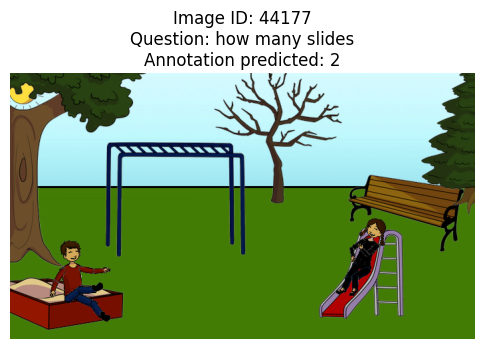

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

# Choose a sample index from the test set, e.g., index 10
sample_idx = 10

# Get test features for that sample (expand dims for model.predict)
sample_image_feat = np.expand_dims(X_test_image[sample_idx], axis=0)
sample_text_feat  = np.expand_dims(X_test_text[sample_idx], axis=0)

# Predict using the model
pred_probs = model_approach2.predict([sample_image_feat, sample_text_feat])
pred_class_idx = np.argmax(pred_probs, axis=1)
pred_answer_str = label_encoder.inverse_transform(pred_class_idx)[0]

# Retrieve metadata from df_questions_test
sample_data = df_questions_test.iloc[sample_idx]
sample_image_id = sample_data["image_id"]
sample_question = sample_data["question"]
sample_choices = sample_data["multiple_choices"]

# Print details
print("Image ID:", sample_image_id)
print("Question:", sample_question)
print("Multiple Choice Options:", sample_choices)
print("Predicted Answer:", pred_answer_str)

# Build the file path for the test image (adjust naming if necessary)
sample_image_path = os.path.join(
    IMAGE_DIR_TEST,
    f"abstract_v002_test2015_{int(sample_image_id):012d}.png"
)

# Load and display the image with a title containing the ID, question, and predicted answer
img = Image.open(sample_image_path)
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.title(f"Image ID: {sample_image_id}\nQuestion: {sample_question}\nAnnotation predicted: {pred_answer_str}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Image ID: 35459
Question: where is the window
Multiple Choice Options: ['on wall', 'under bush', 'wall', 'white', 'dog', '4', 'tie backs', '2', '1', 'no', 'yes', '3', 'next to picture', 'blue', 'red', 'bright red', 'over couch', 'wedges']
Predicted Answer: wall


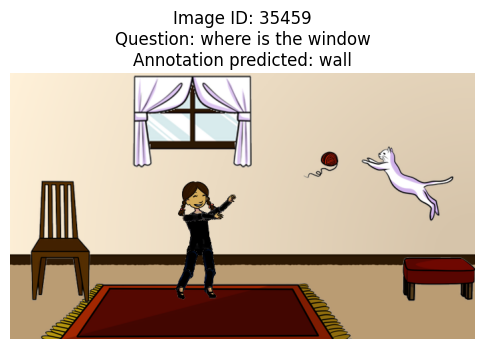

In [ ]:
sample_idx = 15

# Get test features for that sample (expand dims for model.predict)
sample_image_feat = np.expand_dims(X_test_image[sample_idx], axis=0)
sample_text_feat  = np.expand_dims(X_test_text[sample_idx], axis=0)

# Predict using the model
pred_probs = model_approach2.predict([sample_image_feat, sample_text_feat])
pred_class_idx = np.argmax(pred_probs, axis=1)
pred_answer_str = label_encoder.inverse_transform(pred_class_idx)[0]

# Retrieve metadata from df_questions_test
sample_data = df_questions_test.iloc[sample_idx]
sample_image_id = sample_data["image_id"]
sample_question = sample_data["question"]
sample_choices = sample_data["multiple_choices"]

# Print details
print("Image ID:", sample_image_id)
print("Question:", sample_question)
print("Multiple Choice Options:", sample_choices)
print("Predicted Answer:", pred_answer_str)

# Build the file path for the test image (adjust naming if necessary)
sample_image_path = os.path.join(
    IMAGE_DIR_TEST,
    f"abstract_v002_test2015_{int(sample_image_id):012d}.png"
)

# Load and display the image with a title containing the ID, question, and predicted answer
img = Image.open(sample_image_path)
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.title(f"Image ID: {sample_image_id}\nQuestion: {sample_question}\nAnnotation predicted: {pred_answer_str}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Image ID: 35459
Question: did she throw the yarn
Multiple Choice Options: ['they hurt', '1', 'not', 'white', 'pigeon', '2', 'child', '3', 'dog', '4', 'behind left tree', 'yes', 'no', 'cherry', 'she is bored', 'blue', 'red', 'yellow dog']
Predicted Answer: yes


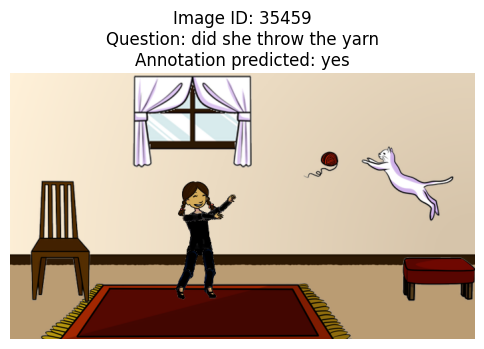

In [ ]:
sample_idx = 16

# Get test features for that sample (expand dims for model.predict)
sample_image_feat = np.expand_dims(X_test_image[sample_idx], axis=0)
sample_text_feat  = np.expand_dims(X_test_text[sample_idx], axis=0)

# Predict using the model
pred_probs = model_approach2.predict([sample_image_feat, sample_text_feat])
pred_class_idx = np.argmax(pred_probs, axis=1)
pred_answer_str = label_encoder.inverse_transform(pred_class_idx)[0]

# Retrieve metadata from df_questions_test
sample_data = df_questions_test.iloc[sample_idx]
sample_image_id = sample_data["image_id"]
sample_question = sample_data["question"]
sample_choices = sample_data["multiple_choices"]

# Print details
print("Image ID:", sample_image_id)
print("Question:", sample_question)
print("Multiple Choice Options:", sample_choices)
print("Predicted Answer:", pred_answer_str)

# Build the file path for the test image (adjust naming if necessary)
sample_image_path = os.path.join(
    IMAGE_DIR_TEST,
    f"abstract_v002_test2015_{int(sample_image_id):012d}.png"
)

# Load and display the image with a title containing the ID, question, and predicted answer
img = Image.open(sample_image_path)
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.title(f"Image ID: {sample_image_id}\nQuestion: {sample_question}\nAnnotation predicted: {pred_answer_str}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image ID: 44172
Question: what is the man reaching for
Multiple Choice Options: ['no', '2', '4', '3', 'white', 'fell', 'red', 'book', 'video games', 'shaking hands', 'blue', 'cell phone', 'dog', '1', 'cat in tree', 'falling', 'yes', 'she ate too much']
Predicted Answer: dog


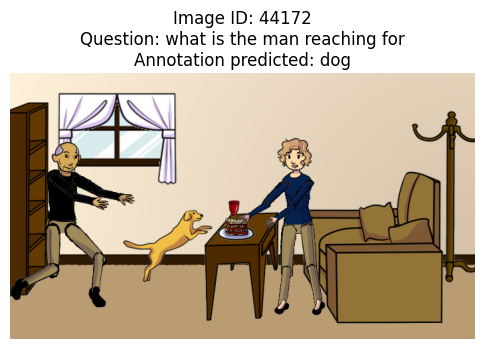

In [ ]:
sample_idx = 18

# Get test features for that sample (expand dims for model.predict)
sample_image_feat = np.expand_dims(X_test_image[sample_idx], axis=0)
sample_text_feat  = np.expand_dims(X_test_text[sample_idx], axis=0)

# Predict using the model
pred_probs = model_approach2.predict([sample_image_feat, sample_text_feat])
pred_class_idx = np.argmax(pred_probs, axis=1)
pred_answer_str = label_encoder.inverse_transform(pred_class_idx)[0]

# Retrieve metadata from df_questions_test
sample_data = df_questions_test.iloc[sample_idx]
sample_image_id = sample_data["image_id"]
sample_question = sample_data["question"]
sample_choices = sample_data["multiple_choices"]

# Print details
print("Image ID:", sample_image_id)
print("Question:", sample_question)
print("Multiple Choice Options:", sample_choices)
print("Predicted Answer:", pred_answer_str)

# Build the file path for the test image (adjust naming if necessary)
sample_image_path = os.path.join(
    IMAGE_DIR_TEST,
    f"abstract_v002_test2015_{int(sample_image_id):012d}.png"
)

# Load and display the image with a title containing the ID, question, and predicted answer
img = Image.open(sample_image_path)
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.title(f"Image ID: {sample_image_id}\nQuestion: {sample_question}\nAnnotation predicted: {pred_answer_str}")
plt.show()


## Prediction on Validation set to comapare with the actual ground truth answers

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Image ID: 20046
Question: how many people are visible
Multiple Choice Options: ['red', '6', 'blue', 'turtle, squirrel, bee', 'real', 'bush', 'brown', 'yes', 'no', '3', '2', '5', 'pine', '4', 'to vent while cooking', '1', '0', 'white']
Ground Truth Annotation: 2
Predicted Answer: 2


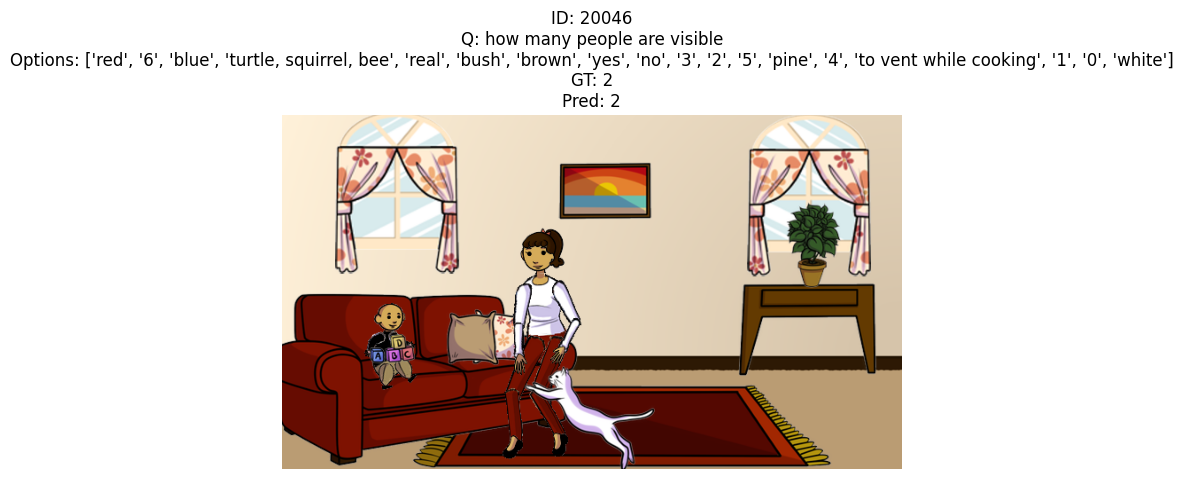

In [ ]:

sample_idx = 10

# Get validation features for that sample (expand dims for model.predict)
sample_image_feat = np.expand_dims(X_val_image[sample_idx], axis=0)
sample_text_feat  = np.expand_dims(X_val_text[sample_idx], axis=0)

# Predict using the model
pred_probs = model_approach2.predict([sample_image_feat, sample_text_feat])
pred_class_idx = np.argmax(pred_probs, axis=1)
pred_answer_str = label_encoder.inverse_transform(pred_class_idx)[0]

# Retrieve metadata from df_val_filtered
sample_data = df_val_filtered.iloc[sample_idx]
sample_image_id = sample_data["image_id"]
sample_question = sample_data["question"]
sample_choices = sample_data["multiple_choices"]

# Get ground truth annotation from the validation dataset (assuming you have it)
# If ground truth is stored in a column, say "multiple_choice_answer"
true_answer_str = sample_data["multiple_choice_answer"]

# Print the details
print("Image ID:", sample_image_id)
print("Question:", sample_question)
print("Multiple Choice Options:", sample_choices)
print("Ground Truth Annotation:", true_answer_str)
print("Predicted Answer:", pred_answer_str)

# Build the file path for the validation image
sample_image_path = os.path.join(
    IMAGE_DIR_VAL,  # Assuming validation images are in this directory
    f"abstract_v002_val2015_{int(sample_image_id):012d}.png"
)

# Load and display the image with details in the title
img = Image.open(sample_image_path)
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis('off')
plt.title(f"ID: {sample_image_id}\nQ: {sample_question}\nOptions: {sample_choices}\nGT: {true_answer_str}\nPred: {pred_answer_str}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Image ID: 29685
Question: is the woman lighting the fire
Multiple Choice Options: ['red', 'woman', 'brown', 'to man', '2', 'blue', 'next to sandbox', 'fell', 'woman is eating poop', '4', 'maybe', '3', 'yes', 'ice cream', 'no', 'she is petting cat', 'white', '1']
Ground Truth Annotation: no
Predicted Answer: yes


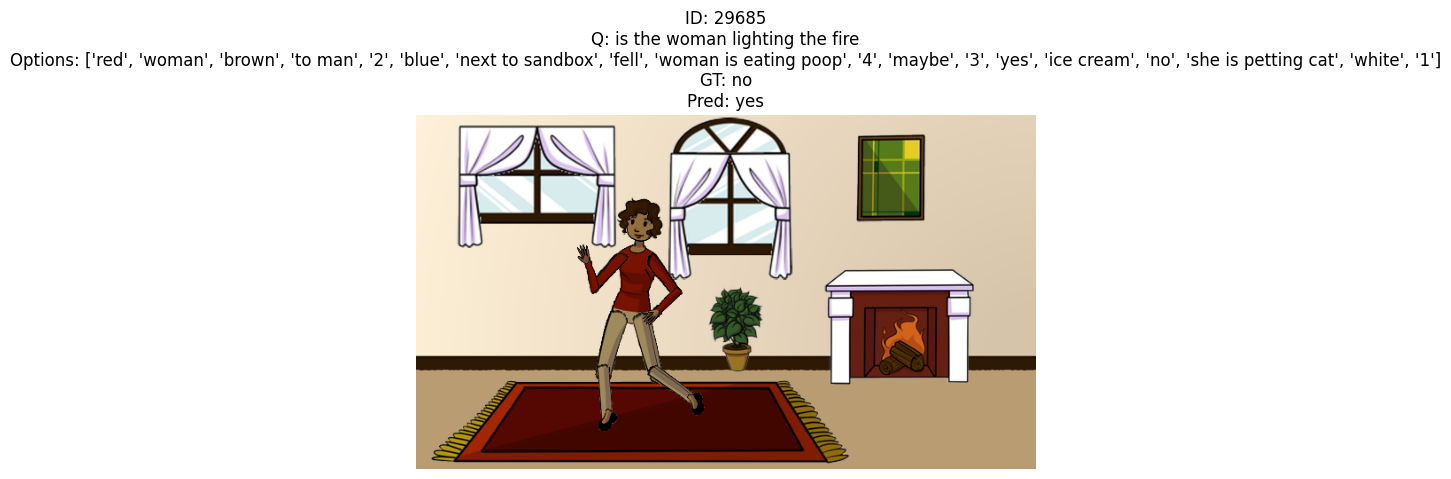

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

# Choose a sample index from the validation set, e.g., index 5
sample_idx = 16

# Get validation features for that sample (expand dims for model.predict)
sample_image_feat = np.expand_dims(X_val_image[sample_idx], axis=0)
sample_text_feat  = np.expand_dims(X_val_text[sample_idx], axis=0)

# Predict using the model
pred_probs = model_approach2.predict([sample_image_feat, sample_text_feat])
pred_class_idx = np.argmax(pred_probs, axis=1)
pred_answer_str = label_encoder.inverse_transform(pred_class_idx)[0]

# Retrieve metadata from df_val_filtered
sample_data = df_val_filtered.iloc[sample_idx]
sample_image_id = sample_data["image_id"]
sample_question = sample_data["question"]
sample_choices = sample_data["multiple_choices"]

# Get ground truth annotation from the validation dataset (assuming you have it)
# If ground truth is stored in a column, say "multiple_choice_answer"
true_answer_str = sample_data["multiple_choice_answer"]

# Print the details
print("Image ID:", sample_image_id)
print("Question:", sample_question)
print("Multiple Choice Options:", sample_choices)
print("Ground Truth Annotation:", true_answer_str)
print("Predicted Answer:", pred_answer_str)

# Build the file path for the validation image
sample_image_path = os.path.join(
    IMAGE_DIR_VAL,  # Assuming validation images are in this directory
    f"abstract_v002_val2015_{int(sample_image_id):012d}.png"
)

# Load and display the image with details in the title
img = Image.open(sample_image_path)
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis('off')
plt.title(f"ID: {sample_image_id}\nQ: {sample_question}\nOptions: {sample_choices}\nGT: {true_answer_str}\nPred: {pred_answer_str}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Image ID: 29685
Question: is the woman alone
Multiple Choice Options: ['cookies', '4', 'brown', 'woman is eating poop', 'blue', '2', 'climbing', '1', 'playing video games', 'by man', 'red', 'getting bottle', 'no', 'bird and sun', '3', 'yes', 'white', 'stood up']
Ground Truth Annotation: yes
Predicted Answer: yes


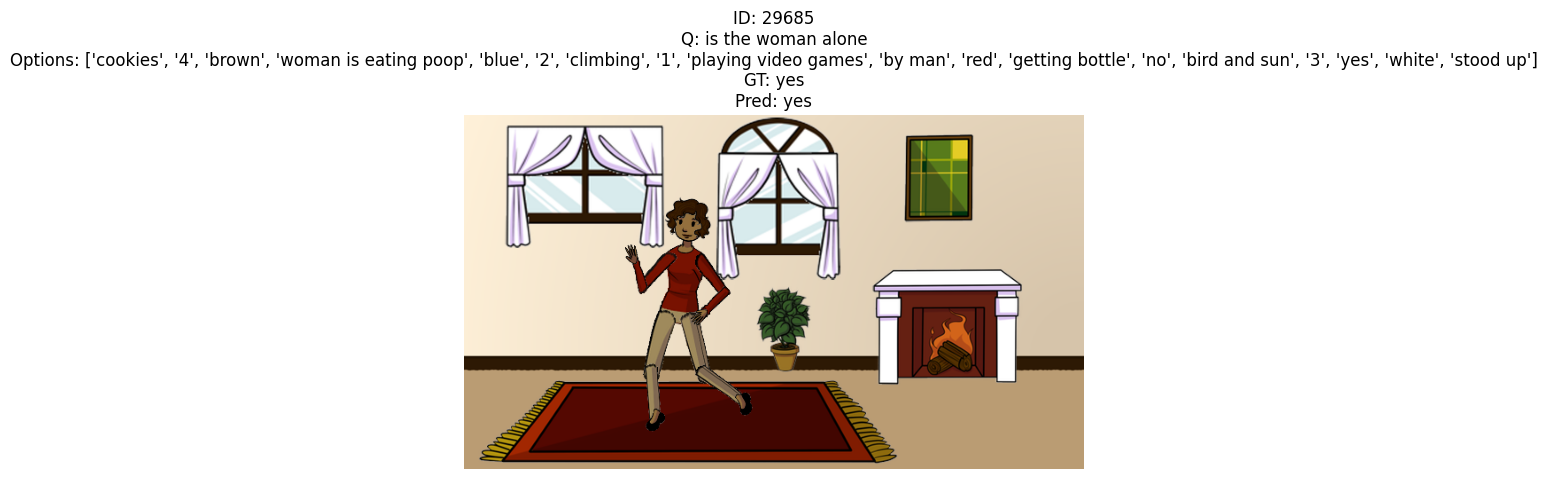

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

# Choose a sample index from the validation set, e.g., index 5
sample_idx = 17

# Get validation features for that sample (expand dims for model.predict)
sample_image_feat = np.expand_dims(X_val_image[sample_idx], axis=0)
sample_text_feat  = np.expand_dims(X_val_text[sample_idx], axis=0)

# Predict using the model
pred_probs = model_approach2.predict([sample_image_feat, sample_text_feat])
pred_class_idx = np.argmax(pred_probs, axis=1)
pred_answer_str = label_encoder.inverse_transform(pred_class_idx)[0]

# Retrieve metadata from df_val_filtered
sample_data = df_val_filtered.iloc[sample_idx]
sample_image_id = sample_data["image_id"]
sample_question = sample_data["question"]
sample_choices = sample_data["multiple_choices"]

# Get ground truth annotation from the validation dataset (assuming you have it)
# If ground truth is stored in a column, say "multiple_choice_answer"
true_answer_str = sample_data["multiple_choice_answer"]

# Print the details
print("Image ID:", sample_image_id)
print("Question:", sample_question)
print("Multiple Choice Options:", sample_choices)
print("Ground Truth Annotation:", true_answer_str)
print("Predicted Answer:", pred_answer_str)

# Build the file path for the validation image
sample_image_path = os.path.join(
    IMAGE_DIR_VAL,  # Assuming validation images are in this directory
    f"abstract_v002_val2015_{int(sample_image_id):012d}.png"
)

# Load and display the image with details in the title
img = Image.open(sample_image_path)
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis('off')
plt.title(f"ID: {sample_image_id}\nQ: {sample_question}\nOptions: {sample_choices}\nGT: {true_answer_str}\nPred: {pred_answer_str}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Image ID: 29685
Question: what is underneath the arched window
Multiple Choice Options: ['seat', 'yes', 'curtains', 'teddy bears', '4', 'blue', 'red', '2', 'under slide', 'coats', 'no', 'behind log', '3', 'brown', '1', 'white', 'plant', 'desk']
Ground Truth Annotation: plant
Predicted Answer: picture


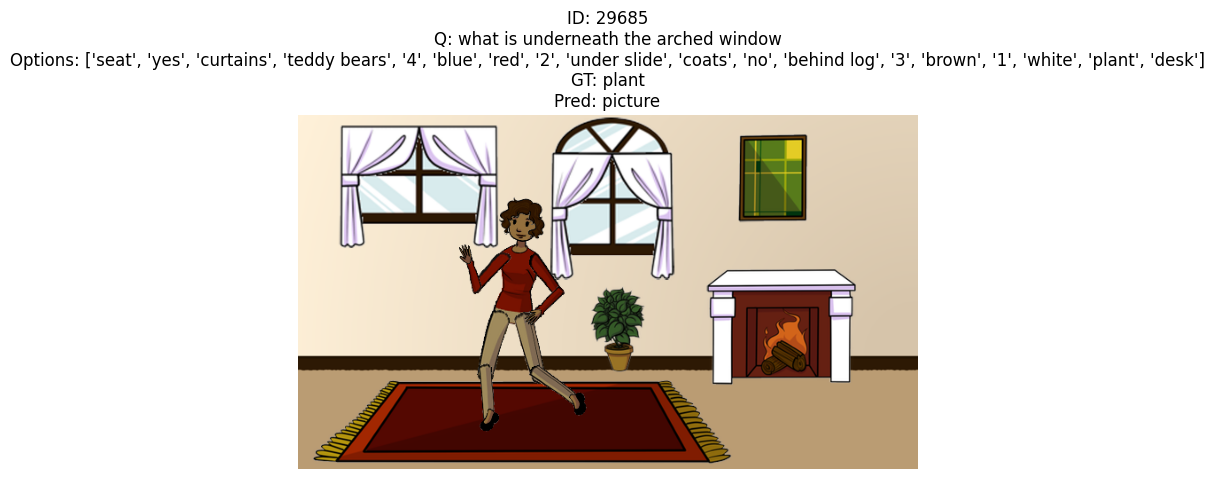

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

# Choose a sample index from the validation set, e.g., index 5
sample_idx = 18

# Get validation features for that sample (expand dims for model.predict)
sample_image_feat = np.expand_dims(X_val_image[sample_idx], axis=0)
sample_text_feat  = np.expand_dims(X_val_text[sample_idx], axis=0)

# Predict using the model
pred_probs = model_approach2.predict([sample_image_feat, sample_text_feat])
pred_class_idx = np.argmax(pred_probs, axis=1)
pred_answer_str = label_encoder.inverse_transform(pred_class_idx)[0]

# Retrieve metadata from df_val_filtered
sample_data = df_val_filtered.iloc[sample_idx]
sample_image_id = sample_data["image_id"]
sample_question = sample_data["question"]
sample_choices = sample_data["multiple_choices"]

# Get ground truth annotation from the validation dataset (assuming you have it)
# If ground truth is stored in a column, say "multiple_choice_answer"
true_answer_str = sample_data["multiple_choice_answer"]

# Print the details
print("Image ID:", sample_image_id)
print("Question:", sample_question)
print("Multiple Choice Options:", sample_choices)
print("Ground Truth Annotation:", true_answer_str)
print("Predicted Answer:", pred_answer_str)

# Build the file path for the validation image
sample_image_path = os.path.join(
    IMAGE_DIR_VAL,  # Assuming validation images are in this directory
    f"abstract_v002_val2015_{int(sample_image_id):012d}.png"
)

# Load and display the image with details in the title
img = Image.open(sample_image_path)
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis('off')
plt.title(f"ID: {sample_image_id}\nQ: {sample_question}\nOptions: {sample_choices}\nGT: {true_answer_str}\nPred: {pred_answer_str}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Image ID: 29627
Question: will the bird fly off with the baby
Multiple Choice Options: ['sky', 'blue', '2', 'white', 'eat', 'not being held', 'cup', 'pillows', '3', 'brown', 'falling', '1', 'none planted', 'red', '4', 'yes', 'half round', 'no']
Ground Truth Annotation: no
Predicted Answer: no


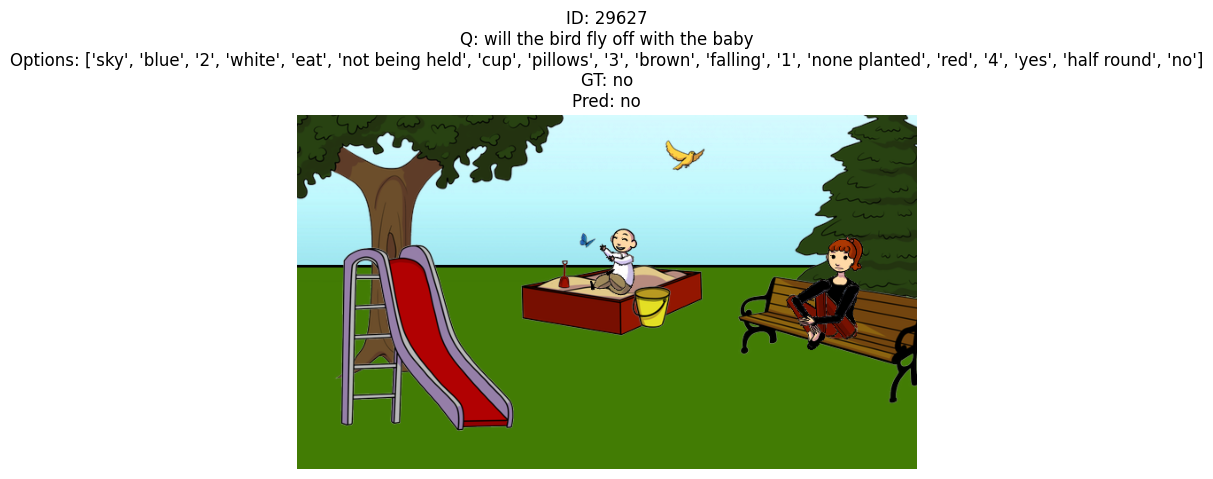

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

# Choose a sample index from the validation set, e.g., index 5
sample_idx = 19

# Get validation features for that sample (expand dims for model.predict)
sample_image_feat = np.expand_dims(X_val_image[sample_idx], axis=0)
sample_text_feat  = np.expand_dims(X_val_text[sample_idx], axis=0)

# Predict using the model
pred_probs = model_approach2.predict([sample_image_feat, sample_text_feat])
pred_class_idx = np.argmax(pred_probs, axis=1)
pred_answer_str = label_encoder.inverse_transform(pred_class_idx)[0]

# Retrieve metadata from df_val_filtered
sample_data = df_val_filtered.iloc[sample_idx]
sample_image_id = sample_data["image_id"]
sample_question = sample_data["question"]
sample_choices = sample_data["multiple_choices"]

# Get ground truth annotation from the validation dataset (assuming you have it)
# If ground truth is stored in a column, say "multiple_choice_answer"
true_answer_str = sample_data["multiple_choice_answer"]

# Print the details
print("Image ID:", sample_image_id)
print("Question:", sample_question)
print("Multiple Choice Options:", sample_choices)
print("Ground Truth Annotation:", true_answer_str)
print("Predicted Answer:", pred_answer_str)

# Build the file path for the validation image
sample_image_path = os.path.join(
    IMAGE_DIR_VAL,  # Assuming validation images are in this directory
    f"abstract_v002_val2015_{int(sample_image_id):012d}.png"
)

# Load and display the image with details in the title
img = Image.open(sample_image_path)
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis('off')
plt.title(f"ID: {sample_image_id}\nQ: {sample_question}\nOptions: {sample_choices}\nGT: {true_answer_str}\nPred: {pred_answer_str}")
plt.show()
